In [1]:
import torch
from torch import nn 
from torch.nn import functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
import time
import math
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# definining general terms

# generate colocation points
import random
random.seed(1)
lower_bound = 0
upper_bound = 8
N_col = 100
t_col = [random.uniform(lower_bound,upper_bound) for _ in range(N_col)]
t_col = torch.tensor(t_col).reshape(1, -1).T

# time for initial condition
t_init = [0.0]
t_init = torch.tensor(t_init).reshape(1, -1).T

In [3]:
class NN(nn.Module):
    def __init__(self,):
        super(NN, self).__init__()
        #Linear layers
        self.mod = nn.Sequential(
            nn.Linear(1, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 1)
        )
        
    def forward(self, inpu):
        out = self.mod(inpu)
        return out

In [4]:
class Model:
    def __init__(self, t_col, t_init, alpha):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN().to(device)
        
        #Max iteration
        self.max_iter = 2000
        
        #Criterion for loss 
        self.criterion = nn.MSELoss()
        
        #Optimizer
        self.optimizer = optim.Adam(self.model.parameters())
        
        #Initialization for training
        
        # frequency
        self.alpha = alpha
        
        # tensor of collocation points
        #Create grid for solution
        self.grid = t_col.to(device)  # no need to create grid for 1D problem
        self.grid.requires_grad = True
        
        # tensor of initial condition points
        # Points for boundary conditions (both are same) 
        self.train_points = t_init.to(device) # Training points as a grid
        self.train_points.requires_grad = True
        
        # function values at initial conditions
        self.u_initial = torch.ones(len(self.train_points)).reshape(1,-1).T.to(device)
        self.ut_initial = -1*torch.ones(len(self.train_points)).reshape(1,-1).T.to(device)

        self.iter = 1
    
    def loss(self):
        # self.lbfgs.zero_grad()
        self.optimizer.zero_grad()
        
        y = self.model(self.train_points) 
        dy_dt = torch.autograd.grad(inputs=self.train_points, outputs=y, grad_outputs=torch.ones_like(y), retain_graph=True, create_graph=True)[0]
        
        loss = self.criterion(y, self.u_initial) #Compute first part of loss
        loss += self.criterion(dy_dt, self.ut_initial) #Compute second part of loss
        
        u = self.model(self.grid)
        #Compute gradients of grid with respect to t
        du_dt = torch.autograd.grad(inputs=self.grid, outputs=u, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        du_dt2 = torch.autograd.grad(inputs=self.grid, outputs=du_dt, grad_outputs=torch.ones_like(du_dt), retain_graph=True, create_graph=True)[0]
        
        #third part of loss, using f(t,x) as in paper
        loss += self.criterion(du_dt2 + 2*du_dt + u, 
                               (1/4)*torch.exp(-self.grid)*(self.alpha**2)*torch.cos(self.alpha*self.grid))  
        
        
        loss.backward()
        #Print loss every 100 iteration
        '''
        if self.iter % 100 == 0: 
            print(self.iter, loss.item())
        self.iter = self.iter + 1
        '''
        return loss

    def train(self):
        for i in range(self.max_iter):
            self.optimizer.step(self.loss)
            #self.lbfgs.step(self.loss)


In [5]:
alpha = 1
model = Model(t_col, t_init, alpha)
model.train()

<bound method Figure.show of <Figure size 2000x500 with 3 Axes>>

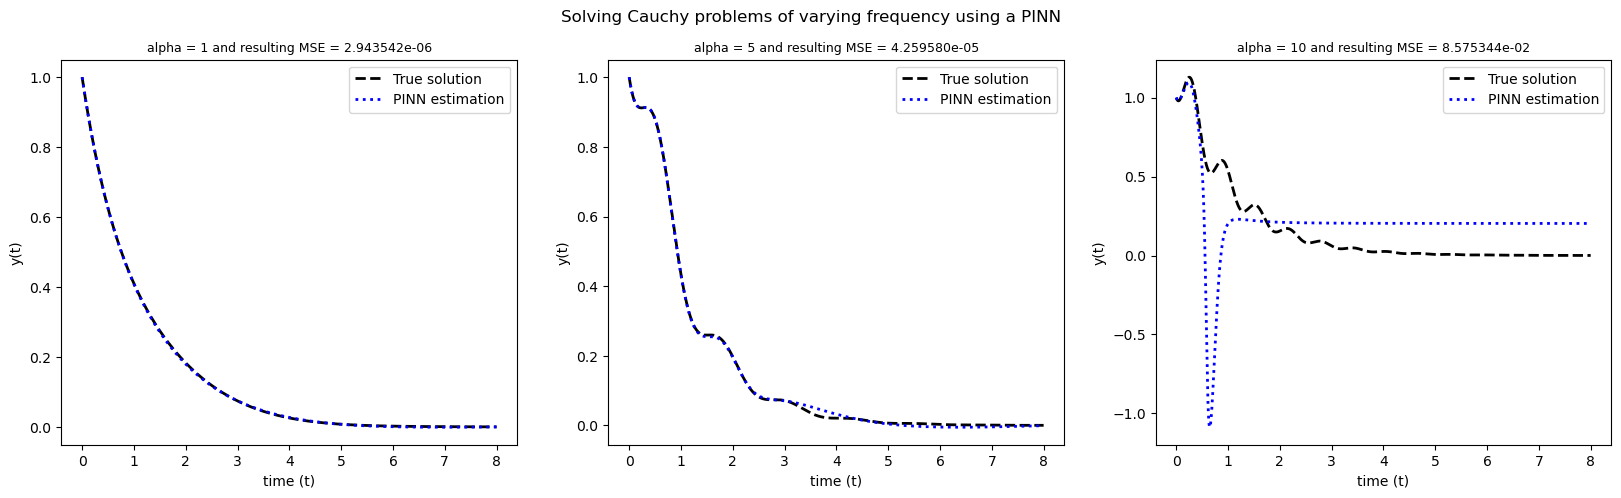

In [6]:
def result_funct(alpha, t):
    return (1/4)*torch.exp(-t)*(5 - torch.cos(alpha*t))

N_fine = 10000
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
t_fine = torch.linspace(lower_bound, upper_bound, steps=N_fine).reshape(1,-1).T.to(device)


alpha_lst = [1,5,10]
error_lst = []

fig, ax = plt.subplots(1,3, figsize=(20, 5))
plt_idx = 0
for alpha in alpha_lst:

    model = Model(t_col, t_init, alpha)
    model.train()

    mod = model.model
    mod.eval()
    with torch.no_grad():
        y_pred = mod(t_fine).cpu()

    mse = nn.MSELoss()
    error = mse(y_pred, result_funct(alpha, t_fine))
    error_lst.append(error)


    ax[plt_idx].plot(t_fine, result_funct(alpha, t_fine), color='black',linestyle='--', linewidth=2, label='True solution')
    ax[plt_idx].plot(t_fine, y_pred, color='blue', linestyle=':', linewidth=2, label='PINN estimation')
    ax[plt_idx].legend()
    ax[plt_idx].set(xlabel="time (t)", ylabel="y(t)")
    ax[plt_idx].set_title('alpha = %d and resulting MSE = %e'%(alpha,error),fontsize=9)
    plt_idx+=1

    
plt.suptitle("Solving Cauchy problems of varying frequency using a PINN")
fig.show

The above results are obtained using 100 randomly distributed colocation points and 2000 iterations for training.